# 12.4 逻辑回归建模实验

接下来进行逻辑回归的建模实验，首先需要导入相关库和自定义模块

In [1]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchLearning import *

from torch.utils.tensorboard import SummaryWriter

# 一个cell输出多个结果
writer = SummaryWriter(log_dir= 'reg_loss')


当然，我们可以通过查看我们自定义的函数帮助文档来验证是否导入成功

In [2]:
tensorGenCla?

Signature:
tensorGenCla(
    num_examples=500,
    num_inputs=2,
    num_class=3,
    deg_dispersion=[4, 2],
    bias=False,
)
Docstring:
分类数据集创建函数
num_examples: 每个类别的数据数量
num_inputs: 数据集特征数量
num_class: 数据集标签类别总数
deg_dispersion: 数据分布离散程度参数，需要输入一个列表，其中第一个参数表示每个类别数组均值的参考，第二个参数表示随机数组标准差。
bias: 建立模型逻辑回归模型时是否带入截距
return: 生成的特征张量和标签张量，其中特征张量是浮点型二维数组，标签张量是长正型二维数组
File:      /media/liu/HP USB321FD/MchineLearning_note/torchLearning.py
Type:      function

## 12.4.1 逻辑回归手动实现

接下来，尝试手动实现二分类逻辑回归，还是根据此前介绍的深度学习建模流程进行手动实现

1. 生成数据集

利用此前创建的tensorGenGla进行二分类数据集的创建

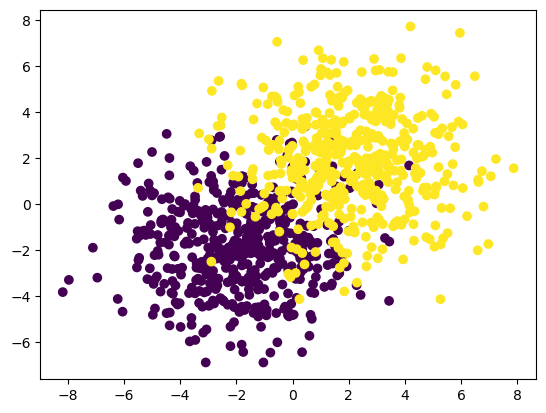

In [2]:
# 设置随机数种子
torch.manual_seed(420)

# 创建数据集
features, labels = tensorGenCla(num_class= 2, bias= True)

# 可视化展示
plt.scatter(features[:, 0], features[:, 1], c = labels)


In [3]:
features

tensor([[-2.0141, -0.9911,  1.0000],
        [-0.6593, -2.7657,  1.0000],
        [-1.9395, -1.2347,  1.0000],
        ...,
        [ 2.9623,  2.0861,  1.0000],
        [ 0.4535, -0.2140,  1.0000],
        [-2.6681,  3.3935,  1.0000]])

2. 建模过程

* Step 1. 模型选择

针对二分类问题（0-1问题）,我们可以简单的输出一个结果，作为标签取值为1的概率，因此模型结构如下：

![Alt text](image-27.png)

对应的可定义如下模型

1）激活函数

In [4]:
def sigmoid(z):
    return 1/(1 + torch.exp(-z))


2）逻辑回归模型

In [5]:
def logistic(X, w):
    return sigmoid(torch.mm(X, w))

3）辅助函数

由于sigmoid 输出结果是连续值，而用于二分类判别时，我们需要将连续数值转化为所判定的类别，可定义如下对应分类函数：

In [6]:
def cal(sigma, p = 0.5):
    return ((sigma >= p).float())

In [8]:
a = torch.randint(10, (5, ))
a

tensor([0, 3, 4, 3, 6])

In [9]:
a >= 5

tensor([False, False, False, False,  True])

In [10]:
(a >= 5).float()

tensor([0., 0., 0., 0., 1.])

另外，对分类模型，我们往往会通过准确率判别模型效果，因此还需要定义准确率函数

In [11]:
def accuracy(y_hat, y):
    acc_bool = cal(y_hat).flatten() == y.flatten()
    acc = torch.mean(acc_bool.float())
    return (acc)

In [12]:
p = torch.tensor([1, 1, 2]) == torch.tensor([1, 1, 2])
p

tensor([True, True, True])

In [13]:
p.float()
torch.mean(p.float())

tensor(1.)

In [16]:
b = torch.randint(low= 1, high= 10, size= (5, 3, 2))
b

tensor([[[6, 1],
         [2, 6],
         [4, 3]],

        [[1, 2],
         [5, 4],
         [9, 6]],

        [[6, 7],
         [8, 1],
         [3, 3]],

        [[1, 5],
         [3, 7],
         [1, 1]],

        [[3, 1],
         [5, 1],
         [7, 8]]])

In [19]:
b.flatten().data

tensor([6, 1, 2, 6, 4, 3, 1, 2, 5, 4, 9, 6, 6, 7, 8, 1, 3, 3, 1, 5, 3, 7, 1, 1,
        3, 1, 5, 1, 7, 8])

    注意：Python中很多的函数操作都并不会改变原变量，而是返回一个新的变量或者是一个新的视图

* Stage 2.定义损失函数

In [21]:
def cross_entropy(sigma, y):
    return (-(1/y.numel()) * torch.sum((1 -y) * torch.log(1 -sigma) + y * torch.log(sigma)))

* Stage 3.定义优化算法

In [22]:
def sgd(params, lr):
    params.data -= lr * params.grad
    params.grad.zero_()

* Stage 4.训练模型

In [23]:
features

tensor([[-2.0141, -0.9911,  1.0000],
        [-0.6593, -2.7657,  1.0000],
        [-1.9395, -1.2347,  1.0000],
        ...,
        [ 2.9623,  2.0861,  1.0000],
        [ 0.4535, -0.2140,  1.0000],
        [-2.6681,  3.3935,  1.0000]])

In [24]:
# 设置随机种子
torch.manual_seed(420)

# 初始化核心参数
batch_size = 10                             # 每一个小批的数量
lr = 0.03                                   # 学习率
num_epochs = 3                              # 训练过程遍历几次数据
w = torch.ones(3, 1, requires_grad= True)   # 随机初始化权重

# 参与训练的模型方程
net = logistic
loss = cross_entropy

# 训练过程
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w), y)
        l.backward()
        sgd(w, lr)
    train_acc = accuracy(cal(net(features, w)), labels)
    print(f'epoch:{epoch + 1}, accracy: {train_acc}')

epoch:1, accracy: 0.9049999713897705
epoch:2, accracy: 0.9079999923706055
epoch:3, accracy: 0.9129999876022339


In [25]:
w

tensor([[1.0154],
        [0.9696],
        [0.5769]], requires_grad=True)

3. 模型调试

根据上述迭代三轮返回的准确率，能够看出整体还在增加，让我们再多迭代几轮查看结果

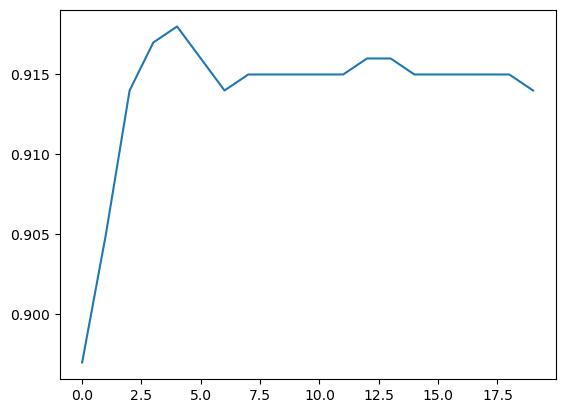

In [30]:
# 设置随机种子
torch.manual_seed(420)

# 初始化核心参数
batch_size = 10                             # 每一个小批的数量
lr = 0.03                                   # 学习率
num_epochs = 20                              # 训练过程遍历几次数据
w = torch.ones(3, 1, requires_grad= True)   # 随机初始化权重

# 参与训练的模型方程
net = logistic
loss = cross_entropy

# 设置列表容器
train_acc = []

# 训练过程
for i in range(num_epochs):
    for epoch in range(i):
        for X, y in data_iter(batch_size, features, labels):
            l = loss(net(X, w), y)
            l.backward()
            sgd(w, lr)
    train_acc.append(accuracy(cal(net(features, w)), labels))

plt.plot(list(range(num_epochs)), train_acc)

## 12.4.2 快速构建逻辑回归模型

1. 构建模型

接下来，我们使用PyTorch中的函数和类，进行逻辑回归的快速构建。

* 定义核心参数

In [60]:
# 初始化核心参数
batch_size = 10                             # 每一个小批的数量
lr = 0.03                                   # 学习率
num_epochs = 3                              # 训练过程遍历几次数据
# w = torch.ones(3, 1, requires_grad= True)   # 随机初始化权重


* 数据准备

In [61]:
# 设置随机数种子
torch.manual_seed(420)

# 创建数据集
features, labels = tensorGenCla(num_class= 2)
labels = labels.float()                         # 损失函数标签要求也要是浮点型
data = TensorDataset(features, labels)
batchData = DataLoader(data, batch_size= batch_size, shuffle= True)

In [62]:
features

tensor([[-2.0141, -0.9911],
        [-0.6593, -2.7657],
        [-1.9395, -1.2347],
        ...,
        [ 2.9623,  2.0861],
        [ 0.4535, -0.2140],
        [-2.6681,  3.3935]])

* Stage 1.定义模型

In [63]:
class logisticR(nn.Module):
    def __init__(self, in_features = 2, out_features = 1):  # 定义模型的点线结构
        super().__init__()
        self.linear_1 = nn.Linear(in_features, out_features, bias= True)
    
    def forward(self, x):
        out = self.linear_1(x)
        return out

# 实例化模型
LG_model = logisticR()

* Stage 2.定义损失函数

In [64]:
criterion = nn.BCEWithLogitsLoss()

* Stage 3.定义优化算法

In [65]:
optimizer = optim.SGD(LG_model.parameters(), lr= 0.03)


* Stage 4.模型训练

In [66]:
def fit(net, criterion, optimizer, batchdata, epochs):
    for epoch in range(epochs):
        for X,y in batchdata:
            zhat = net.forward(X)
            loss = criterion(zhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    和线性回归相同，由于上述模型只有一层，因此也可以通过nn.Linear(2, 1)函数直接建模。由于我们所采用的BCEWithlogitsloss类进行的损失函数求解，该类会自动对输入对象进行sigmoid转化，因此上述过程和线性回归过程没有区别

In [67]:
torch.manual_seed(420)

fit(net=LG_model,
    criterion= criterion,
    optimizer= optimizer,
    batchdata= batchData,
    epochs= num_epochs)

* 计算准确率

In [68]:
def acc_zhat(zhat, y):
    """ 输入为线性方程计算结果，输出为逻辑回归准确率的函数
    param zhat: 线性方程输出结果
    param y: 数据集标签张量
    return: 准确率
    """
    
    sigma = sigmoid(zhat)
    return accuracy(sigma, y)

In [69]:
acc_zhat(LG_model(features), labels)

tensor(0.9130)

2. 模型调试

同样，我们首先尝试多迭代几次，看下准确率如何发生变化

In [70]:
# 设置随机数种子
torch.manual_seed(420)

# 创建数据集
features, labels = tensorGenCla(num_class= 2)
labels = labels.float()                         # 损失函数标签要求也要是浮点型
data = TensorDataset(features, labels)
batchData = DataLoader(data, batch_size= batch_size, shuffle= True)

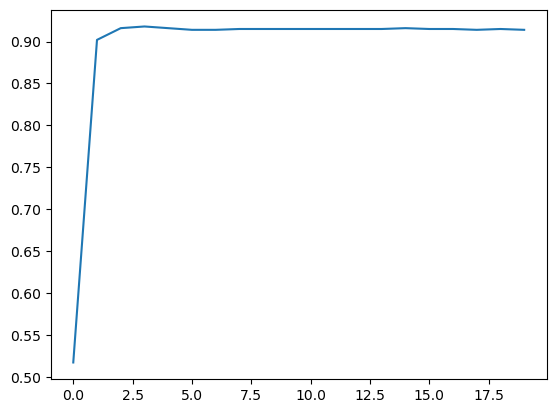

In [79]:
# 设置随机数种子
torch.manual_seed(420)

# 初始化核心参数
num_epochs = 20
LG = logisticR()
cr1 = nn.BCEWithLogitsLoss()
op1 = optim.SGD(LG.parameters(), lr= lr)

# 创建列表容器
train_acc = []

# 执行建模
for epochs in range(num_epochs):    # 当epochs为0时，就是未经过训练时的模型的表现性能
    fit(net=LG,
        criterion= cr1,
        optimizer= op1,
        batchdata= batchData,
        epochs= epochs)
    epoch_acc = acc_zhat(LG(features), labels)
    train_acc.append(epoch_acc)

# 绘制图像查看准确率变化情况
plt.plot(list(range(num_epochs)), train_acc)
    

In [80]:
train_acc

[tensor(0.5170),
 tensor(0.9020),
 tensor(0.9160),
 tensor(0.9180),
 tensor(0.9160),
 tensor(0.9140),
 tensor(0.9140),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9160),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9140),
 tensor(0.9150),
 tensor(0.9140)]